# Object detection with data augmentation

When we have a dark green part in an image, our model incorrectly detects it as a frog and fails to detect the object that we are interested in. I assumed that if I add variety to training images, maybe it can construct more accurate prediciton model. To add variety, or data augmentation, I think a quick approach is to use built-in function of data augmentation with Keras. Long story short, this approach failed to improve. Next step is maybe 2 options. Change color more dicrectly by using imgaug library, and the other is to improve layers in neural network image classification model. The model weights in this code is calculated by model_2_augmentation.ipynb.

## Setup

In [68]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import cv2

from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import cifar10

## Hyperparameter 

In [40]:
model_path = "C:/Users/yukic/OneDrive/git/object_detection/models/model_2_aug.h5"
label_name = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']) 
image_file = "C:/Users/yukic/OneDrive/git/object_detection/images/cat_02.jpg"
idx_target = 3
RESIZE = 8
channel = 3
input_size = 32
filename_1 = 'idx_matrix_x8_cat_02_model_2_aug.sav'
filename_2 = 'prob_matrix_x8_cat_02_model_2_aug.sav'
imagename_1 = "max_prob_matrix_cat_02_model_2_aug"
imagename_2 = "target_prob_matrix_cat_02_model_2_aug"
imagename_3 = "multi_box_cat_02_model_2_aug"
imagename_4 = "single_box_cat_02_model_2_aug"
title_1 = "Max probs matrix (Model 2 aug)"
title_2 = "Target probs matrix (Model 2 aug)"
title_3 = "Bounding boxes extraction (Model 2 aug)"
title_4 = "Model 2 aug"

## Load image

Height: 388
Width: 600
Channel: RGB
Height multiplied by width: 232,800


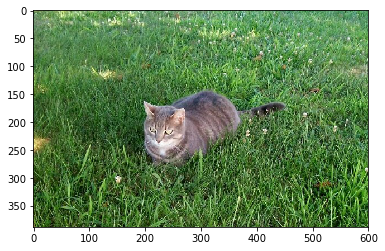

In [41]:
img = Image.open(image_file)
print("Height:", img.size[1])
print("Width:", img.size[0])
print("Channel:", img.mode)
print("Height multiplied by width: {:,}".format(img.size[0] * img.size[1]))

plt.imshow(img)
plt.show()

## Load model

In [42]:
loaded_model = load_model(model_path)
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

## Resize

Resized to (75, 48)
New height 48
New width 75
Number of prediction: 3,600


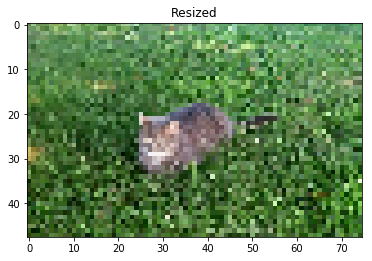

In [43]:
# resize (PIL resize is (width, height), not (height, width))
new_width = img.size[0] // RESIZE
new_height = img.size[1] // RESIZE
img_x = img.resize((new_width, new_height))

print("Resized to", img_x.size)
print("New height", new_height)
print("New width", new_width)
print("Number of prediction: {:,}".format(new_height*new_width))

plt.imshow(img_x)
plt.title("Resized")
plt.show()

## Preprocess

In [44]:
img_x_ar = np.array(img_x)

# in numpy, we operate by first height, second width
img_x_proc = img_x_ar.reshape((-1, new_height, new_width, channel))
img_x_proc = img_x_proc.astype("float32")
img_x_proc /= 255

print("Size of preprocessed image", img_x_proc.shape)

Size of preprocessed image (1, 48, 75, 3)


## Prediction

In [45]:
# update prediction range
pred_height = new_height - input_size + 1
pred_width = new_width - input_size + 1
print("Prediction matrix has {} by {}".format(pred_height, pred_width))

Prediction matrix has 17 by 44


In [46]:
# prediction

# in numpy, we operate by first height, second width 
idx_matrix_x = np.zeros((pred_height, pred_width))
prob_matrix_x = np.zeros((pred_height, pred_width))

# target matrix
target_prob_matrix = np.zeros((pred_height, pred_width))

img_proc = img_x_proc

# sliding windows
for j in range(pred_height):
    for i in range(pred_width):
        # in numpy, we operate by first height, second width 
        tmp = img_proc[:, j:(input_size+j), i:(input_size+i), :]
        pred_tmp = loaded_model.predict(tmp)
        idx_max = np.argmax(pred_tmp)
        prob_max = np.max(pred_tmp)
        
        # target prob
        prob_target = pred_tmp[0][idx_target]

        # store values
        idx_matrix_x[j, i] = idx_max
        prob_matrix_x[j, i] = prob_max
        target_prob_matrix[j, i] = prob_target

## Visualize prediction

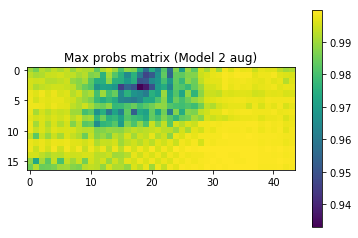

In [47]:
plt.imshow(prob_matrix_x)
plt.title(title_1)
plt.colorbar()
plt.savefig(imagename_1)
plt.show()

Maximum probability of target: 0.0155


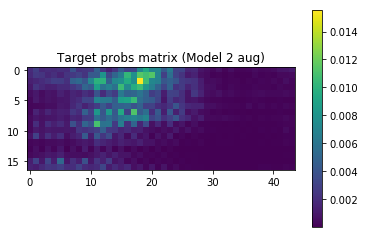

In [48]:
print("Maximum probability of target:", np.round(np.max(target_prob_matrix), decimals = 4))

plt.imshow(target_prob_matrix)
plt.title(title_2)
plt.colorbar()
plt.savefig(imagename_2)
plt.show()

## Cat

In [51]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


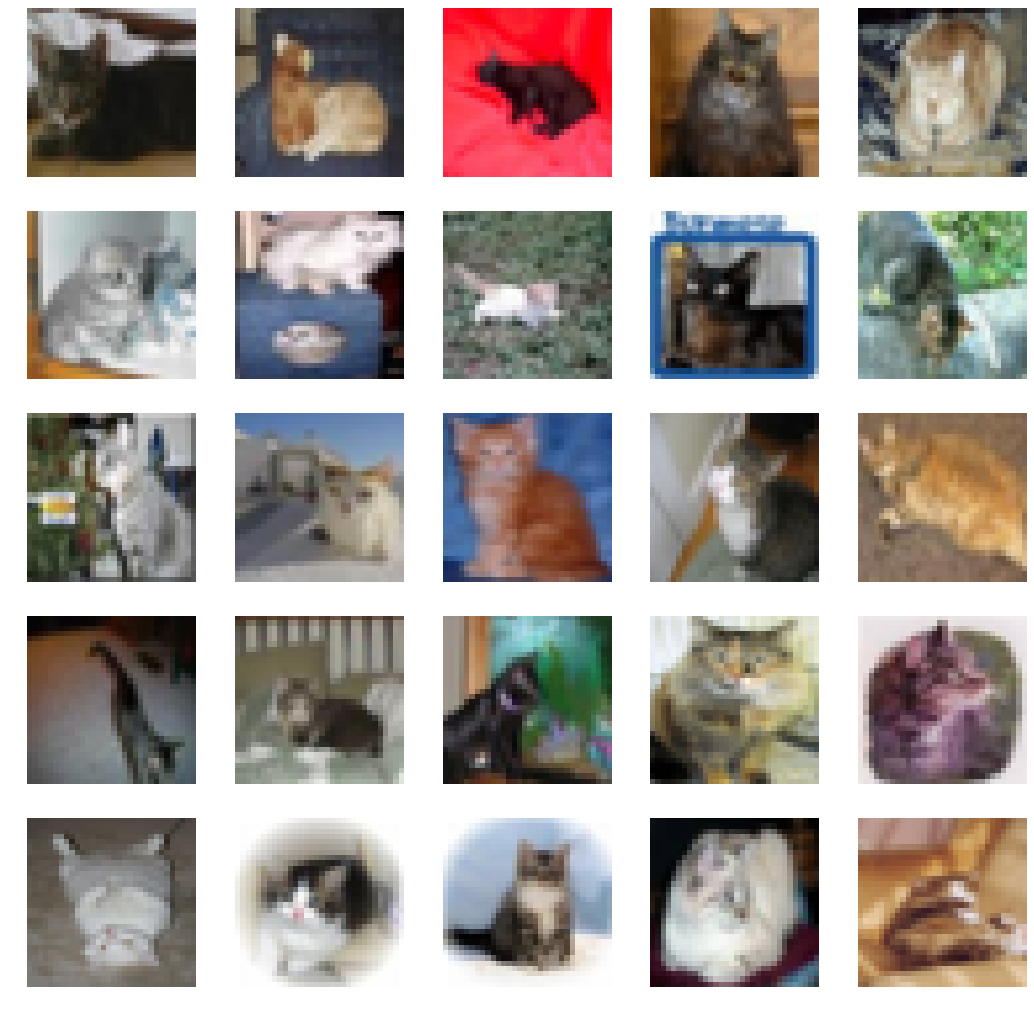

In [53]:
CAT_IDXS = np.where(y_train == idx_target)[0]
x_train_cat = x_train[CAT_IDXS]

plt.figure(figsize = (18, 18))

num = 0
for i in range(25):
    num += 1
    plt.subplot(5, 5, num)
    plt.imshow(x_train_cat[i])
    plt.axis('off')

plt.show()

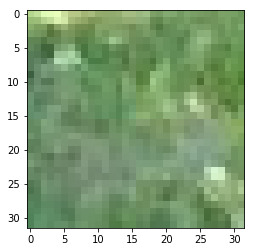

        label   prob
0    airplane  0.000
1  automobile  0.000
2        bird  0.116
3         cat  0.041
4        deer  0.092
5         dog  0.004
6        frog  0.745
7       horse  0.001
8        ship  0.000
9       truck  0.000


In [72]:
tmp = np.array(img)[:32, :32, :]
plt.imshow(tmp)
plt.show()

tmp = np.reshape(tmp, newshape = (1, 32, 32, 3))
tmp = tmp.astype("float32")
tmp /= 255

pred = np.round(loaded_model.predict(tmp), decimals = 3)
df = pd.DataFrame({'label':label_name, 'prob':pred[0]})
print(df)

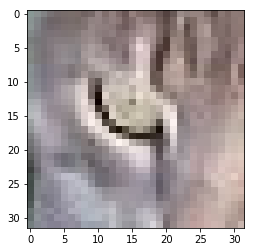

        label   prob
0    airplane  0.001
1  automobile  0.000
2        bird  0.028
3         cat  0.304
4        deer  0.293
5         dog  0.017
6        frog  0.355
7       horse  0.002
8        ship  0.000
9       truck  0.000


In [73]:
tmp = np.array(img)[200:200+32, 200:200+32, :]
plt.imshow(tmp)
plt.show()

tmp = np.reshape(tmp, newshape = (1, 32, 32, 3))
tmp = tmp.astype("float32")
tmp /= 255

pred = np.round(loaded_model.predict(tmp), decimals = 3)
df = pd.DataFrame({'label':label_name, 'prob':pred[0]})
print(df)

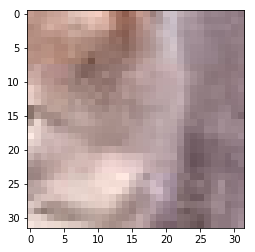

        label   prob
0    airplane  0.000
1  automobile  0.000
2        bird  0.134
3         cat  0.194
4        deer  0.074
5         dog  0.006
6        frog  0.591
7       horse  0.001
8        ship  0.000
9       truck  0.000


In [85]:
tmp = np.array(img)[200:200+32, 250:250+32, :]
plt.imshow(tmp)
plt.show()

tmp = np.reshape(tmp, newshape = (1, 32, 32, 3))
tmp = tmp.astype("float32")
tmp /= 255

pred = np.round(loaded_model.predict(tmp), decimals = 3)
df = pd.DataFrame({'label':label_name, 'prob':pred[0]})
print(df)

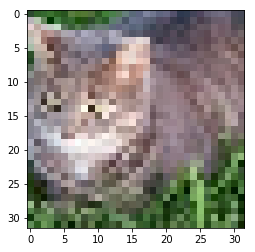

        label   prob
0    airplane  0.000
1  automobile  0.000
2        bird  0.008
3         cat  0.012
4        deer  0.008
5         dog  0.000
6        frog  0.971
7       horse  0.000
8        ship  0.000
9       truck  0.000


In [83]:
new_width = img.size[0] // 4
new_height = img.size[1] // 4
img_x = img.resize((new_width, new_height))

tmp = np.array(img_x)[40:40+32, 50:50+32, :]
plt.imshow(tmp)
plt.show()

tmp = np.reshape(tmp, newshape = (1, 32, 32, 3))
tmp = tmp.astype("float32")
tmp /= 255

pred = np.round(loaded_model.predict(tmp), decimals = 3)
df = pd.DataFrame({'label':label_name, 'prob':pred[0]})
print(df)

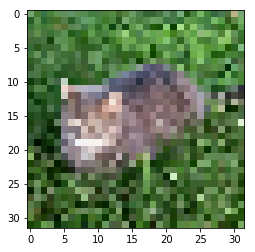

        label   prob
0    airplane  0.000
1  automobile  0.000
2        bird  0.002
3         cat  0.001
4        deer  0.004
5         dog  0.000
6        frog  0.994
7       horse  0.000
8        ship  0.000
9       truck  0.000


In [84]:
new_width = img.size[0] // 8
new_height = img.size[1] // 8
img_x = img.resize((new_width, new_height))

tmp = np.array(img_x)[10:10+32, 20:20+32, :]
plt.imshow(tmp)
plt.show()

tmp = np.reshape(tmp, newshape = (1, 32, 32, 3))
tmp = tmp.astype("float32")
tmp /= 255

pred = np.round(loaded_model.predict(tmp), decimals = 3)
df = pd.DataFrame({'label':label_name, 'prob':pred[0]})
print(df)